In [16]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# =========================
# Utilities
# =========================

def required_initial_max_distance(max_dist_final, n_steps):
    D = max_dist_final
    for _ in range(n_steps):
        D = 3 * D + 2
    return D

def logsumexp(values):
    values = np.asarray(values, dtype=float)
    m = np.max(values)
    return m + np.log(np.sum(np.exp(values - m)))

# =========================
# Majority configurations (3-spin cell)
# =========================

_all_spins = np.array(list(product([-1, 1], repeat=3)), dtype=int)
plus_configs  = _all_spins[np.sum(_all_spins, axis=1) >=  1]
minus_configs = _all_spins[np.sum(_all_spins, axis=1) <= -1]

# =========================
# Intracell energies
# =========================

def intracell_energies(spins, J):
    J1 = J[1] if len(J) > 1 else 0.0
    J2 = J[2] if len(J) > 2 else 0.0

    E = np.empty(spins.shape[0], dtype=float)
    for i, (s0, s1, s2) in enumerate(spins):
        E[i] = J1 * (s0 * s1 + s1 * s2) + J2 * (s0 * s2)
    return E

# =========================
# RG step: J -> J'
# =========================

def renormalized_coupling_for_r(r, J):
    D = len(J) - 1  # max distance available

    # Precompute intracell energies
    E_plus  = intracell_energies(plus_configs,  J)
    E_minus = intracell_energies(minus_configs, J)

    # Positions of spins in the left and right cells
    left_pos  = np.array([0, 1, 2])
    right_pos = np.array([3 * r + 0, 3 * r + 1, 3 * r + 2])

    # Precompute distances between them
    distances = np.abs(right_pos[None, :] - left_pos[:, None])  # shape (3,3)

    # R(++): left-majority+, right-majority+
    totals_pp = []
    for iL, sL in enumerate(plus_configs):
        EL = E_plus[iL]
        for iR, sR in enumerate(plus_configs):
            ER = E_plus[iR]
            E_int = 0.0
            for a in range(3):
                for b in range(3):
                    d = distances[a, b]
                    if d <= D:
                        E_int += J[d] * sL[a] * sR[b]
            totals_pp.append(EL + ER + E_int)

    # R(+-): left-majority+, right-majority-
    totals_pm = []
    for iL, sL in enumerate(plus_configs):
        EL = E_plus[iL]
        for iR, sR in enumerate(minus_configs):
            ER = E_minus[iR]
            E_int = 0.0
            for a in range(3):
                for b in range(3):
                    d = distances[a, b]
                    if d <= D:
                        E_int += J[d] * sL[a] * sR[b]
            totals_pm.append(EL + ER + E_int)

    log_R_pp = logsumexp(totals_pp)
    log_R_pm = logsumexp(totals_pm)

    # Spin-flip symmetry: J'_r = 1/2 [ln R(++ ) - ln R(+-)]
    return 0.5 * (log_R_pp - log_R_pm)

def rg_step(J):
    D = len(J) - 1
    r_max = (D - 2) // 3
    if r_max < 1:
        raise ValueError("Not enough range in J to perform another RG step.")

    J_new = np.zeros(r_max + 1, dtype=float)  # index 0 unused
    for r in range(1, r_max + 1):
        J_new[r] = renormalized_coupling_for_r(r, J)

    return J_new

# =========================
# RG flow driver (full, proper)
# =========================

def generate_rg_flow(J0, a, max_dist_final, n_steps, trace_TM=False, TM_r=1):
    D0 = required_initial_max_distance(max_dist_final, n_steps)

    # initial couplings
    J = np.zeros(D0 + 1)
    d = np.arange(1, D0 + 1)
    J[1:] = J0 / (d ** a)

    J_list = []
    TM_list = [] if trace_TM else None

    for step in range(n_steps + 1):
        J_list.append(J)

        if trace_TM and TM_r < len(J):
            T = construct_transfer_matrix(J, TM_r, normalize=True)
            TM_list.append(T)

        if step == n_steps:
            break

        J = rg_step(J)

    return J_list, TM_list


def extract_flows(J_list, max_dist_final):
    n_steps_plus_1 = len(J_list)
    flows = np.zeros((n_steps_plus_1, max_dist_final + 1), dtype=float)
    for step, J in enumerate(J_list):
        D_curr = len(J) - 1
        r_max_record = min(max_dist_final, D_curr)
        flows[step, :r_max_record + 1] = J[:r_max_record + 1]
    return flows

def plot_rg_flow(flows, distances_to_plot=None):
    n_steps_plus_1, max_dist_plus_1 = flows.shape
    max_dist = max_dist_plus_1 - 1
    steps = np.arange(n_steps_plus_1)

    if distances_to_plot is None:
        distances_to_plot = range(1, max_dist + 1)

    for r in distances_to_plot:
        if r <= max_dist:
            plt.plot(steps, flows[:, r], marker='o', label=f"J_{r}")

    plt.xlabel("RG step")
    plt.ylabel("Coupling J_r")
    plt.title("RG flow of couplings")
    plt.legend()
    plt.tight_layout()
    plt.show()

# =========================
# 2x2 transfer matrix for a chosen distance index
# =========================

def construct_transfer_matrix(J, r, normalize=True):
    if r >= len(J):
        raise ValueError(f"Cannot build transfer matrix: distance r={r} > max available {len(J)-1}")

    Jr = J[r]
    T = np.array([
        [np.exp(Jr),   np.exp(-Jr)],
        [np.exp(-Jr),  np.exp(Jr)]
    ], dtype=float)

    if normalize:
        T = T / np.max(T)

    return T

def determine_phase_from_TM(T, threshold=0.1):
    L = T[0, 0]
    R = T[0, 1]

    if L > 1 - threshold and R > 1 - threshold:
        return "disorder"
    if L > 1 - threshold and R < threshold:
        return "ferromagnetic"

    return "undetermined"

def find_phase(J0, a, TM_r=1, max_dist_final=5, n_steps=5, threshold=0.1):
    # initial long-range cutoff
    D0 = required_initial_max_distance(max_dist_final, n_steps)

    # initial interaction function
    J = np.zeros(D0 + 1, dtype=float)
    d = np.arange(1, D0 + 1)
    J[1:] = J0 / (d ** a)

    for step in range(n_steps + 1):
        # construct transfer matrix if possible
        if TM_r < len(J):
            T = construct_transfer_matrix(J, TM_r, normalize=True)
            phase = determine_phase_from_TM(T, threshold=threshold)

            if phase != "undetermined":
                return phase, step

        if step == n_steps:
            break

        J = rg_step(J)
    return "undetermined", n_steps

def find_critical_J(a, J_low=1e-2, J_high=1e2, TM_r=1, max_dist_final=5,
                    n_steps=5, threshold=0.1, tol=1e-3, max_iter=20):

    # --- Ensure bracketing validity ---
    phase_low, _  = find_phase(J_low,  a,
                               TM_r=TM_r,
                               max_dist_final=max_dist_final,
                               n_steps=n_steps,
                               threshold=threshold)
    if phase_low != "disorder":
        raise ValueError(f"J_low={J_low} does not yield disorder (got {phase_low})")
        
    phase_high, _ = find_phase(J_high, a,
                               TM_r=TM_r,
                               max_dist_final=max_dist_final,
                               n_steps=n_steps,
                               threshold=threshold)
    if phase_high != "ferromagnetic":
        raise ValueError(f"J_high={J_high} does not yield ferromagnetic (got {phase_high})")

    # --- Bisection loop ---
    for _ in range(max_iter):

        J_mid = 0.5 * (J_low + J_high)

        phase_mid, _ = find_phase(J_mid, a,
                                  TM_r=TM_r,
                                  max_dist_final=max_dist_final,
                                  n_steps=n_steps,
                                  threshold=threshold)

        # Disorder side → shift lower bound up
        if phase_mid == "disorder":
            J_low = J_mid
        # Ferro side → shift upper bound down
        elif phase_mid == "ferromagnetic":
            J_high = J_mid
        else:
            # Undetermined → leave interval but continue bisecting
            # (this matches behavior in the attached RG code)
            pass

        # Check convergence
        if abs(J_high - J_low) < tol:
            break

    return 0.5 * (J_low + J_high)

def compute_critical_line(a_values, J_low_init=1e-2, J_high_init=1e2,
                          TM_r=1, max_dist_final=5, n_steps=5,
                          threshold=0.1, tol=1e-3, max_iter=20):
    Jc_list = []

    J_low  = J_low_init
    J_high = J_high_init

    for a in a_values:

        # ---------------------------
        # Find J_c for this a
        # ---------------------------
        Jc = find_critical_J(
            a,
            J_low, J_high,
            TM_r=TM_r,
            max_dist_final=max_dist_final,
            n_steps=n_steps,
            threshold=threshold,
            tol=tol,
            max_iter=max_iter
        )

        Jc_list.append(Jc)

        # Update bracketing interval around the new Jc
        #J_low  = 0.5 * Jc
        #J_high = 2.0 * Jc

    return np.array(Jc_list, dtype=float)

def plot_critical_temperatures(a_values, Jc_values):
    Tc = 1.0 / Jc_values

    plt.plot(a_values, Tc, marker="o", linestyle="-")
    plt.xlabel("Interaction Range Exponent   a")
    plt.ylabel("Critical Temperature   1 / J_c")
    plt.title("Critical Line:  Temperature vs Interaction Exponent")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def compute_and_plot_critical_line(a_min=1.0, a_max=2.0, n_points=20, J_low_init=0.01, J_high_init=10.0,
                                   TM_r=1, max_dist_final=8, n_steps=25, threshold=0.1):
    a_values = np.linspace(a_min, a_max, n_points)
    
    Jc_values = compute_critical_line(a_values, J_low_init=J_low_init, J_high_init=J_high_init,
        TM_r=TM_r, max_dist_final=max_dist_final, n_steps=n_steps, threshold=threshold)

    plot_critical_temperatures(a_values, Jc_values)
    return a_values, Jc_values

In [17]:
def full_rg_map(J_full):
    """
    One RG step on the full coupling vector.
    J_full: 1D array, index 0 unused, length D+1.
    Returns: Jp_full with length D1+1.
    """
    return rg_step(J_full)

def compute_full_recursion_matrix(J_full, eps=1e-6):
    """
    Compute the full recursion (Jacobian) matrix for the *actual* RG map.

      J_full (size D)  ->  Jp_full (size D1)
      T_{ij} ≈ d J'_i / d J_j

    Shape:
      D  = len(J_full) - 1
      D1 = len(Jp_full) - 1
      T: (D1 x D)
    """
    D  = len(J_full) - 1
    Jp = full_rg_map(J_full)
    D1 = len(Jp) - 1

    T = np.zeros((D1, D), dtype=float)

    for j in range(1, D+1):
        J_pert = J_full.copy()
        J_pert[j] += eps
        Jp_pert = full_rg_map(J_pert)

        # assumes same D1 (RG structure fixed by input length)
        diff = (Jp_pert[1:D1+1] - Jp[1:D1+1]) / eps
        T[:, j-1] = diff

    return T, Jp

def build_initial_guess(Jc, a, D):
    """
    Build full-dimension initial coupling vector J[0..D]
    from Jc and power-law decay exponent a.
    J[0] unused by convention.
    """
    J = np.zeros(D+1)
    for r in range(1, D+1):
        J[r] = Jc / (r**a)
    return J
    
def newton_rg_shrink(J_init,
                     max_iter=10,
                     tol=1e-8,
                     eps=1e-6,
                     damping=1.0,
                     verbose=False):
    """
    Newton method where each RG reduces dimension D → D1.
    At each iteration:
      • Build rectangular T: (D1 × D)
      • Drop last (D−D1) columns → square T_square
      • Solve T_square * delta = (J'[:D1] - J[:D1])
      • New J has dimension D1
    """
    J = J_init.copy()

    for it in range(max_iter):
        D = len(J) - 1
        T, Jp = compute_full_recursion_matrix(J, eps=eps)
        D1 = len(Jp) - 1

        if D1 < 1:
            if verbose: print("No couplings left.")
            return J, {"converged": False}

        r = Jp[1:D1+1] - J[1:D1+1]
        res_norm = np.linalg.norm(r)

        if verbose:
            print(f"[shrink] iter {it}: D={D}, D1={D1}, ||J'-J||={res_norm:.3e}")

        if res_norm < tol:
            return J, {
                "converged": True,
                "final_dim": D,
                "iterations": it
            }

        # Keep first D1 columns to make square matrix
        T_square = T[:, :D1]     # shape (D1, D1)

        try:
            delta = np.linalg.solve(T_square, r)
        except np.linalg.LinAlgError:
            if verbose: print("Singular square Jacobian.")
            return J, {"converged": False, "error": "singular T_square"}

        # J_{new} has dimension D1 (tail dropped)
        J_new = np.zeros(D1+1)
        J_new[1:D1+1] = J[1:D1+1] - damping * delta

        J = J_new

    return J, {"converged": False, "iterations": max_iter}

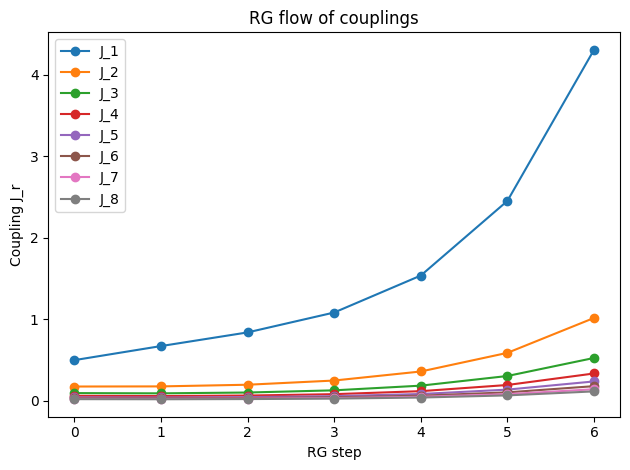

In [2]:
J0 = 0.5
a = 1.5
max_dist_final = 8
n_steps = 6

J_list, T_list = generate_rg_flow(J0, a, max_dist_final, n_steps, trace_TM=True, TM_r=1)
flows = extract_flows(J_list, max_dist_final)
plot_rg_flow(flows, distances_to_plot=[1, 2, 3, 4, 5, 6, 7, 8])

In [5]:
J0 = 1
a = 1.5

phase, step = find_phase(
        J0, a,
        TM_r=1,
        max_dist_final=8,
        n_steps=5,
        threshold=0.1
    )
print(f"Phase at J0={J0}, a={a}: {phase} (decided at step {step})")

Phase at J0=1, a=1.5: ferromagnetic (decided at step 1)


In [3]:
a = 1.5
J_low  = 0.1    # disorder
J_high = 10.0    # ferromagnetic

Jc = find_critical_J(a, J_low, J_high)
print("Critical J:", Jc)
print("Critical Temperature (1/J):", 1.0/Jc)

Critical J: 0.409375
Critical Temperature (1/J): 2.4427480916030535


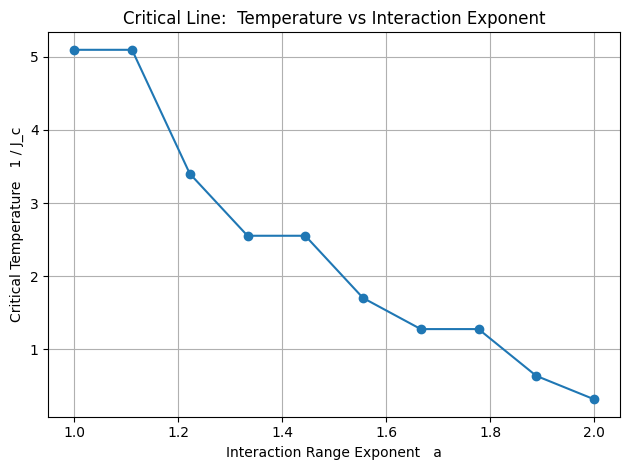

In [12]:
# Scan a from 1 to 2 using 15 points
a_vals, Jc_vals = compute_and_plot_critical_line(
    a_min=1.0,
    a_max=2.0,
    n_points=10,
    J_low_init=1/1000,
    J_high_init=100.0,
    TM_r=2,
    max_dist_final=5,
    n_steps=5,
    threshold=0.1,)

In [36]:
Jc = find_critical_J(a=1.5, J_low=0.001,
    J_high=100.0,
    TM_r=1,
    max_dist_final=10,
    n_steps=6,
    threshold=0.1,
    tol=0.001,
    max_iter=20,)
Jc

0.39162109375

In [37]:
J0 = build_initial_guess(Jc, a=1.5, D=1000)
J0

array([0.00000000e+00, 3.91621094e-01, 1.38458966e-01, ...,
       1.24213919e-05, 1.24027458e-05, 1.23841464e-05], shape=(1001,))

In [ ]:
J_star, info = newton_rg_lstsq(J0, verbose=True)
J_star